# Определение возраста покупателей

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

## Исследовательский анализ данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)  

Found 7591 validated image filenames.


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.shape

(7591, 2)

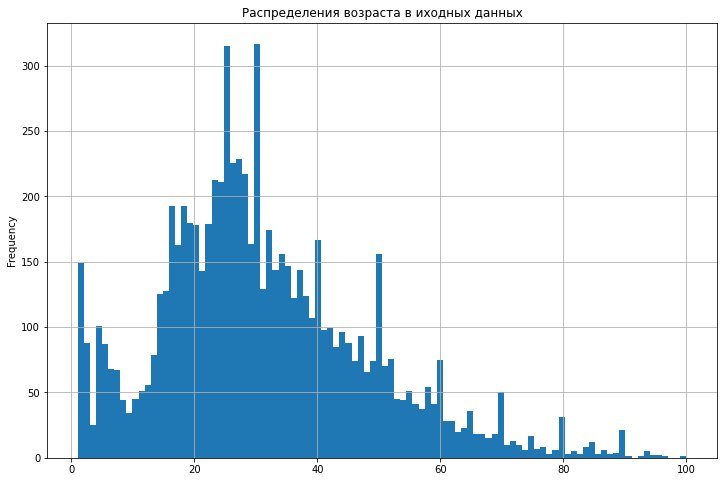

In [61]:
plt.figure()
labels['real_age'].plot(kind='hist', 
                        grid=True, 
                        figsize=(12,8), 
                        bins=100,
                        xlabel = 'Возраст',
                        title='Распределения возраста в иходных данных');

In [53]:
labels.groupby('real_age').count().head(20).T

real_age,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
file_name,149,88,25,101,87,68,67,44,34,45,51,56,79,125,128,193,163,193,180,178


In [105]:
labels.groupby('real_age').count().iloc[25:].T

real_age,26,27,28,29,30,31,32,33,34,35,...,88,89,90,91,93,94,95,96,97,100
file_name,226,229,217,164,317,129,174,144,156,147,...,3,4,21,1,1,5,2,2,1,1


In [63]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Как видим данные на графике распределены неравномерно и есть просадки в некоторых возрастных категориях. Больше всего фотографий для лиц от 14 до 40 лет.

Выведем случайные 5 фотографий людей и их возраст

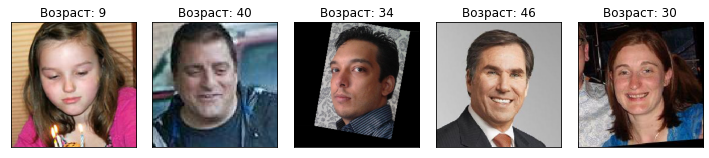

In [15]:
features, target = next(train_gen_flow)


fig = plt.figure(figsize=(10,10))
for i in range(5):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title('Возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

In [17]:
features.shape

(32, 224, 224, 3)

Для обучения моделей даны квадратные цветные фотографии размерностью в 224 точки. Основная часть пар фото-возраст соответсвует возрастному критерию 20-41. Некоторые возрастные группы представлены в единичных экземплярах и очевидно, что точный возраст для некоторых возрастов определить будет невозможно, поэтому рекомендовано было бы объединить некоторые возраста в категории (например: дети, подростки, взрослые, пожилые).
Для супермаркета особенно вожно определять совершеннолетие покупателя, чтобы ограничить возможность в покупке определенных категорий товаров. В пограничной зоне 16-20 лет представленно достаточно большое количество фотографий.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [106]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(2, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Результаты обучения:

Train for 178 steps, validate for 60 steps<br>
Epoch 1/10<br>
178/178 - 66s - loss: 192.7955 - mae: 10.2169 - val_loss: 445.7577 - val_mae: 16.0345<br>
Epoch 2/10<br>
178/178 - 51s - loss: 92.0148 - mae: 7.2176 - val_loss: 451.7124 - val_mae: 16.1872<br>
Epoch 3/10<br>
178/178 - 52s - loss: 68.6918 - mae: 6.3159 - val_loss: 429.8841 - val_mae: 15.5845<br>
Epoch 4/10<br>
178/178 - 52s - loss: 52.3643 - mae: 5.5509 - val_loss: 480.4401 - val_mae: 18.5414<br>
Epoch 5/10<br>
178/178 - 51s - loss: 38.9084 - mae: 4.7773 - val_loss: 126.2638 - val_mae: 8.7828<br>
Epoch 6/10<br>
178/178 - 52s - loss: 36.5956 - mae: 4.5910 - val_loss: 89.8351 - val_mae: 7.3560<br>
Epoch 7/10<br>
178/178 - 51s - loss: 28.1620 - mae: 4.0976 - val_loss: 102.2060 - val_mae: 7.6877<br>
Epoch 8/10<br>
178/178 - 52s - loss: 23.8569 - mae: 3.7121 - val_loss: 75.5281 - val_mae: 6.3656<br>
Epoch 9/10<br>
178/178 - 50s - loss: 18.8138 - mae: 3.3444 - val_loss: 69.9061 - val_mae: 6.1709<br>
Epoch 10/10<br>
178/178 - 48s - loss: 16.2523 - mae: 3.1018 - val_loss: 88.0730 - val_mae: 6.9229<br>
<br>
60/60 - 10s - loss: 88.0730 - mae: 6.9229<br>
Test MAE: 6.9229<br>

## Анализ обученной модели

Подобрав оптимальные параметры обучающей модели ResNet50 удалось добиться требуемого значения функции потерь (MSE) <7 на 10 эпохах, тем не менее достаточно было 8. Общее время обучения модели заняло порядка 10 минут.

ВЫВОД: Супермаркетом «Хлеб-Соль» был предоставлен датасет из 7591 фотографий людей и соответствующего им возраста. Возрастной промежуток составил от 1 до 100 лет. Построив график распределения, было обнаружено, что данное распределение неравномерное и большая часть фотографий соответствовала возрастной категории 20-41 год. Имеются просадки в категории 8-12 лет, а также спрад после 26 лет с некоторыми "всплесками". Были выведены несколько произвольных фотографии для проверки адекватности предоставленных данных.
В качестве модели машинного обучения была выбрана Resnet50, которая позволила добиться заданной точности.